In [1]:
from __future__ import division, print_function, absolute_import

import tflearn
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.normalization import local_response_normalization
from tflearn.layers.estimator import regression
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf

%matplotlib inline

In [2]:
import LoadDataset

In [3]:
IMG_WIDTH = 64 # Side for each transformed Image
IMG_HEIGHT = 32
IMG_DEPTH = 1 # RGB files

In [4]:
DATSET_SIZE =  10000
NUM_LABELS = 3

In [14]:
data = LoadDataset.getFixedNumDigistsDataSet(DATSET_SIZE, NUM_LABELS)
imgs = data[1]
labels = data[2]
numPoints = data[0]

In [15]:
print (numPoints)
print (labels.shape)
print (imgs.shape)

8691
(8691, 3)
(8691, 32, 64)


[4 4 5]


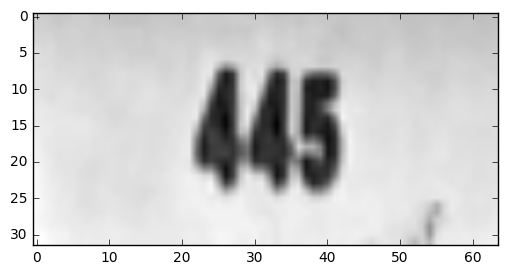

In [16]:
print (labels[0])
plt.imshow(imgs[0], cmap='gray')

In [17]:
def dense_to_one_hot(labels_dense, num_classes=10):
    """Convert class labels from scalars to one-hot vectors."""
    num_labels = labels_dense.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_one_hot = np.zeros((num_labels, num_classes))
    index_update = [int(x) for x in index_offset + labels_dense.ravel()]
    labels_one_hot.flat[index_update] = 1
    return labels_one_hot

In [18]:
# Get the dataset
X = imgs.reshape([-1, IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH])
Y = labels

In [19]:
# Generate validation set
ratio = 0.8 # Train/Test set
randIdx = np.random.random(numPoints) <= ratio
#print (sum(map(lambda x: int(x), randIdx)))
X_train = X[randIdx]
Y_train = Y[randIdx]
X_test = X[randIdx == False]
Y_test = Y[randIdx == False]
Y_train = [dense_to_one_hot(Y_train[:,idx], num_classes= 11) for idx in range(Y_train.shape[1])] 
Y_test = [dense_to_one_hot(Y_test[:,idx], num_classes= 11) for idx in range(Y_test.shape[1])] 
del X, Y # release some space

In [20]:
print (X_train.shape)

(6955, 32, 64, 1)


In [31]:
print (np.mean(Y_train[1], axis = 0))

[ 0.13587347  0.13501078  0.11646298  0.10769231  0.09892164  0.09489576
  0.08741912  0.08670022  0.0728972   0.06412653  0.        ]


In [34]:
# Building convolutional network
for numLayers in [3,4,5]: # Num of Conv layer sets to use
    with tf.Graph().as_default():
        input = input_data(shape=[None, IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH], name='input')

        # Building convolutional network
        x = tflearn.conv_2d(input, 64, 3, activation='relu', name='conv1_1')
        x = tflearn.conv_2d(x, 64, 3, activation='relu', name='conv1_2')
        x = tflearn.max_pool_2d(x, 2, strides=2, name='maxpool1')

        if numLayers >= 2:
            x = tflearn.conv_2d(x, 128, 3, activation='relu', name='conv2_1')
            x = tflearn.conv_2d(x, 128, 3, activation='relu', name='conv2_2')
            x = tflearn.max_pool_2d(x, 2, strides=2, name='maxpool2')
    
        if numLayers >= 3:
            x = tflearn.conv_2d(x, 256, 3, activation='relu', name='conv3_1')
            x = tflearn.conv_2d(x, 256, 3, activation='relu', name='conv3_2')
            x = tflearn.conv_2d(x, 256, 3, activation='relu', name='conv3_3')
            x = tflearn.max_pool_2d(x, 2, strides=2, name='maxpool3')

        if numLayers >= 4:
            x = tflearn.conv_2d(x, 512, 3, activation='relu', name='conv4_1')
            x = tflearn.conv_2d(x, 512, 3, activation='relu', name='conv4_2')
            x = tflearn.conv_2d(x, 512, 3, activation='relu', name='conv4_3')
            x = tflearn.max_pool_2d(x, 2, strides=2, name='maxpool4')

        if numLayers >= 5:
            x = tflearn.conv_2d(x, 512, 3, activation='relu', name='conv5_1')
            x = tflearn.conv_2d(x, 512, 3, activation='relu', name='conv5_2')
            x = tflearn.conv_2d(x, 512, 3, activation='relu', name='conv5_3')
            x = tflearn.max_pool_2d(x, 2, strides=2, name='maxpool5')

        # Training heads
        allHeads = []
        for idx in range(NUM_LABELS):
            fc = fully_connected(x, 1024, activation='tanh')
            fc = dropout(fc, 0.8)
            #fc = fully_connected(fc, 1024, activation='tanh')
            #fc = dropout(fc, 0.8)
            softmax = fully_connected(fc, 11, activation='softmax')
            networkOut = regression(softmax, optimizer='adam', learning_rate=0.01,
                         loss='categorical_crossentropy', name='target' + str(idx))
            allHeads.append(networkOut)

        network = tflearn.merge(allHeads, mode='elemwise_sum')
        model = tflearn.DNN(network, tensorboard_verbose=1)
        feedTrainDict = {'target'+ str(i): Y_train[i] for i in range(NUM_LABELS)}
        feedTestList =  [Y_test[i] for i in range(NUM_LABELS)]
#        model.fit({'input': X_train}, feedTrainDict, 
#                  validation_set= (X_test, feedTestList), n_epoch=5, snapshot_step=100, show_metric=True, run_id='convnet_mnist')
        model.fit({'input': X_train}, feedTrainDict, n_epoch=3, show_metric=True, run_id='convnet_mnist')

        open('/tmp/asd.out','a').write(str(numLayers) + " -> " + str(model.evaluate(X_test,feedTestList, batch_size=16)))

Training Step: 327  | total loss: 9.01312
| Adam_0 | epoch: 003 | loss: 2.91279 - acc: 0.3818 -- iter: 6955/6955
| Adam_1 | epoch: 003 | loss: 3.21344 - acc: 0.1362 -- iter: 6955/6955
| Adam | epoch: 003 | loss: 2.88690 - acc: 0.1188 -- iter: 6955/6955
Training Step: 327  | total loss: 9.01312
| Adam_0 | epoch: 003 | loss: 2.91279 - acc: 0.3818 -- iter: 6955/6955
| Adam_1 | epoch: 003 | loss: 3.21344 - acc: 0.1362 -- iter: 6955/6955
| Adam | epoch: 003 | loss: 2.88690 - acc: 0.1188 -- iter: 6955/6955
--
